In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator


def border():
    bwith = 2 #边框宽度设置为2
    ax = plt.gca()#获取边框
    ax.tick_params(axis="x", direction="in", length=16, width=5, color="k")
    ax.tick_params(axis="x", direction="in", length=16, width=5, color="k")
    # ax.spines['top'].set_color('grey')  # 设置上‘脊梁’为红色
    # ax.spines['right'].set_color('grey')  # 设置右‘脊梁’为无色
    # ax.spines['left'].set_color('grey')  # 设置上‘脊梁’为红色
    # ax.spines['bottom'].set_color('none')  # 设置右‘脊梁’为无色
    ax.spines['bottom'].set_linewidth(bwith)
    ax.spines['left'].set_linewidth(bwith)
    ax.spines['top'].set_linewidth(bwith)
    ax.spines['right'].set_linewidth(bwith)
    
with open("sys",'r') as f:
    sys=f.read()

In [2]:
# 将设备按照latency从弱到强到强分为n个group
def staged(listTemp, n):
    listTemp = np.sort(listTemp)
    n = len(listTemp) // n + 1
    for i in range(0, len(listTemp), n):
        yield listTemp[i:i + n]

def cut(x,y,upper_bound_acc):
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y

def sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous=0, straggler=0, energy_sum=1):
    client_num = 5
    comm_tmp = comm[method.tolist().index(m)]
    duration = 0
    for i in range(0, idx - tmp):
        if heterogenous:
            l = random.choice(latency)
            if straggler: # Only work in heterogenous scenario
                for j in range(client_num - 1):
                    l = max(l,random.choice(latency)) 
            comp_tmp = l * batch_num / latency_rpi[method.tolist().index("Origin")] * latency_rpi_cached[method.tolist().index(m)]
        else:
            comp_tmp = l[method.tolist().index(m)] * batch_num
        if energy_sum:
            duration = duration + comm_tmp
        else:
            duration = duration + comp_tmp + comm_tmp
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time

def sum_duration(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous=0, straggler=0, energy_sum=1):
    client_num = 5
    comm_tmp = comm[method.tolist().index(m)]
    duration = 0
    for i in range(0, idx - tmp):
        if heterogenous:
            l = random.choice(latency)
            if straggler: # Only work in heterogenous scenario
                for j in range(client_num - 1):
                    l = max(l,random.choice(latency)) 
            comp_tmp = l * batch_num / latency_rpi[method.tolist().index("Origin")] * latency_rpi[method.tolist().index(m)]
        else:
            comp_tmp = l[method.tolist().index(m)] * batch_num
        if energy_sum:
            duration = duration + comm_tmp
        else:
            duration = duration + comp_tmp + comm_tmp
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time
    
def insert_0(time, y):
    time.insert(0,0)
    # y = y.tolist()
    y.insert(0,0)
    return time, y

In [3]:
# strong device dominate
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

lower, upper = 1, 20
mu, sigma = 10, 6
num_bins = 20
device_number = 100
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
x = X.rvs(device_number)
s_fit = np.linspace(x.min(), x.max())

latency = x 
latency
latency = np.sort(latency)
latency_stage = list(staged(latency,3))

throughput = x / 20
latency = 1 / throughput

latency = np.sort(latency)
latency_stage = list(staged(latency,3))


method = np.array(["Origin", "Freeze: e", "Freeze: e+0", "Freeze: e,0-1", "Freeze: e,0-2", "Freeze: e,0-3", "Freeze: e,0-4", "Freeze: e,0-5",
           "Adapter", "A-Freeze: e", "A-Freeze: e+0", "A-Freeze: e,0-1", "A-Freeze: e,0-2", "A-Freeze: e,0-3", "A-Freeze: e,0-4", "A-Freeze: e,0-5"])

model_size = np.array([268.0, 172.4, 144.0, 116.0, 87.6, 59.2, 30.8, 2.4,
                1.8, 1.8, 1.52, 1.2, 0.92, 0.64, 0.32, 0.04])

latency_rpi = np.array([18.27, 17.03, 15.03, 13.12, 11.83, 9.63, 8.02, 5.28,
                12.01, 11.65, 10.78, 9.87, 8.76, 7.85, 6.98, 7.05])

latency_rpi_cached = np.array([18.27, 16.28, 14.2, 10.89, 8.04, 5.7, 2.88, 0.14,
                        11.25, 10.94, 9.92, 7.9, 5.96, 4.27, 2.14, 0.15])

latency_tx2 = latency_rpi / 20
latency_tx2_cached = latency_rpi_cached / 20

bw = 1 # both for upload and download bandwidth
batch_num = 20 # per round
multiple = 1 * 20
# overhead
comm = model_size * 2 / bw
comp = latency_rpi * batch_num

# color for lines
ft = 60 # font size
lw = 8 # line width
color = ['darkred','darkblue','darkgreen','darkorange','darkviolet']
linestyle = [(0, ()), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4))]
marker = ["o", "v", "s", "^", "D", "o"]

type = ["FT", "FTQ", r"LF$_{oracle}$", r"LFQ$_{oracle}$", sys]


In [4]:
def down_sample(x, mul = 5):
    # print(len(x))
    if isinstance(x, list):
        x = np.array(x)
    x = [x[i] for i in range(len(x)) if i % mul == 0]
    # print(len(x))
    return x

Origin 32.904444444444444
quantize 4.1875
Freeze: e,0-4 11.310444444444304
Freeze: e,0-4 1.4095277777777604
Ours 0.4604444444444362


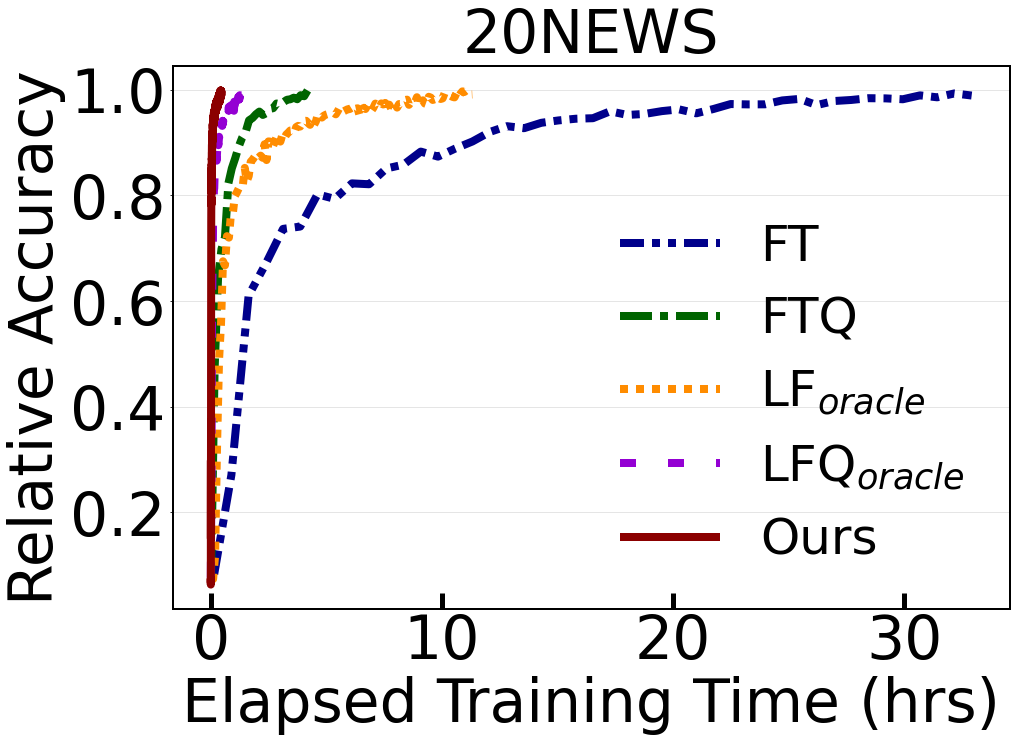

In [5]:
path = "./Baseline/TC_20news_BN_8_experiments.csv" # 除了最后3列，都是multiple = 10
raw_data = pd.read_csv(path,index_col=0)
column_name = raw_data.columns.values

bw = 1 # both for upload and download bandwidth
batch_num = 29 # per round
multiple = 1
# overhead
comm = model_size * 2 / bw
comp = latency_rpi * batch_num

# 使用相同的设备
# TX2 / RPI
plt.figure(figsize=(15,10))
plt.title("20NEWS",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
plt.ylabel("Relative Accuracy", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()

from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

backend = "TX2"
heterogenous = 0
straggler = 0
max_acc = 0.8 * 0.99

# Optimal Freeze + Origin


# 无cache
if backend == "TX2":
    l = latency_tx2
else:
    l = latency_rpi
# Origin
col = "Origin"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
y_ewm = raw_data.iloc[:,column_name.tolist().index(col)].dropna().ewm(span=3).mean()
# y = [t for t in y if t < 0.8]
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]

time = down_sample(time,5)
y = down_sample(y,5)
# time, y = insert_0(time, y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[1], linewidth = lw, label = type[0],linestyle = linestyle[1])
print(col,np.array(time)[-1]/3600)


# Quantize
col = "Origin"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm/8, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
# time, y = insert_0(time, y)
time = down_sample(time,8)
y = down_sample(y,8)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[2], linewidth = lw, label = type[1],linestyle = linestyle[2])
print("quantize",np.array(time)[-1]/3600)

# Freeze-optimal
col = "Freeze: e,0-4"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值

round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
# time, y = insert_0(time, y)
time = down_sample(time)
y = down_sample(y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[3], linewidth = lw, label = type[2],linestyle = linestyle[3])
print(col,np.array(time)[-1]/3600)

# Freeze-optimal
col = "Freeze: e,0-4"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值

round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm/8, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
# time, y = insert_0(time, y)
time = down_sample(time,7)
y = down_sample(y,7)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[4], linewidth = lw, label = type[3], linestyle = linestyle[4])
print(col,np.array(time)[-1]/3600)

# adaptive
# 使用阶梯式adaptive方案来训练，提升0-3freeze方案的效果
data = raw_data.iloc[:,column_name.tolist().index("A-Freeze: e,0-3")].dropna()

time = []
if backend == "TX2":
    l = latency_tx2_cached
else:
    l = latency_rpi_cached

tmp = -1 * multiple # 记录最后一个访问的idx
round_idx = np.array(list(range(0,len(data)))) * multiple # multiple对应eval的频率，和BN的大小
for idx in round_idx:
    if idx < 10 * multiple:
        m = "A-Freeze: e,0-3" 
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    else:
        m = "A-Freeze: e,0-3" 
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time_adaptive = time 

time_adaptive, data = cut(time_adaptive, data, max_acc)
data = data[:len(time_adaptive)]
# time_adaptive, data = insert_0(time_adaptive, data)
# plt.plot(time_adaptive,data_ewm, color= color[2],label="Adaptive")
plt.plot(np.array(time_adaptive)/3600, np.array(data)/max_acc, color = color[0], linewidth = lw, label=type[4], linestyle = linestyle[0])
print(sys,np.array(time_adaptive)[-1]/3600)

plt.legend(fontsize=50,ncol = 1,frameon=False)
plt.savefig('../figs/eval-performance-distilbert-20news.pdf', bbox_inches="tight")

Origin 4.02 0.863815789
Origin 1.005
Freeze: e,0-4 1.7795555555555582
Freeze: e,0-4 0.21602777777777807
Ours 0.06222222222222227


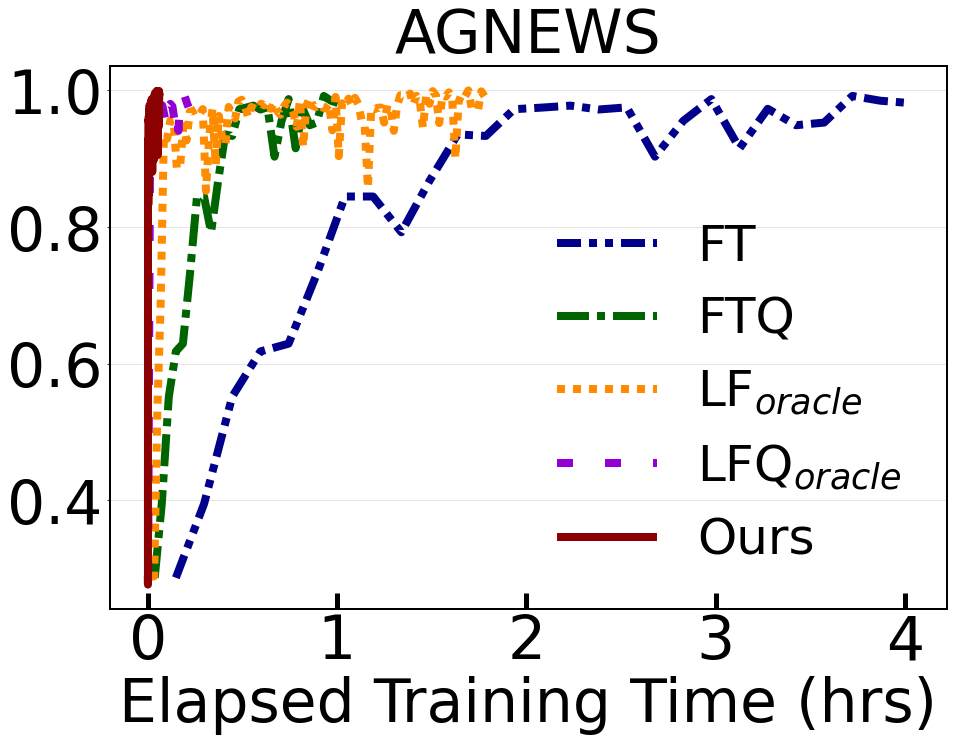

In [6]:
path = "./Baseline/TC-Agnews-processed-data.csv"
raw_data = pd.read_csv(path,index_col=0)
column_name = raw_data.columns.values

bw = 1 # both for upload and download bandwidth
batch_num = 30 # per round
multiple = 1
# overhead
comm = model_size * 2 / bw
comp = latency_rpi * batch_num

# 使用相同的设备
# TX2 / RPI
plt.figure(figsize=(15,10))
plt.title("AGNEWS",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
# plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()

from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

backend = "RPI"
heterogenous = 0
straggler = 0
max_acc = 0.88


# Optimal Freeze + Origin


# 无cache
if backend == "TX2":
    l = latency_tx2
else:
    l = latency_rpi

# Origin
col = "Origin"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
# time, y = insert_0(time, y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[1], linewidth = lw, label = type[0], linestyle = linestyle[1])
print(col,np.array(time)[-1]/3600, np.array(y)[-1])

col = "Origin"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm/4, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
# time, y = insert_0(time, y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[2], linewidth = lw, label = type[1], linestyle = linestyle[2])
print(col,np.array(time)[-1]/3600)

# Freeze-optimal
col = "Freeze: e,0-4"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
# time, y = insert_0(time, y)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[3], linewidth = lw, label = type[2], linestyle = linestyle[3])
print(col,np.array(time)[-1]/3600)


# Freeze-optimal
col = "Freeze: e,0-4"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm/8, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
time = down_sample(time,5)
y = down_sample(y,5)
# time, y = insert_0(time, y)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[4], linewidth = lw, label = type[3], linestyle = linestyle[4])
print(col,np.array(time)[-1]/3600)

# adaptive
# 使用阶梯式adaptive方案来训练，提升0-3freeze方案的效果
data = raw_data.iloc[:,column_name.tolist().index("A-Freeze: e,0-3")].dropna()

time = []
if backend == "TX2":
    l = latency_tx2_cached
else:
    l = latency_rpi_cached

tmp = -1 * multiple # 记录最后一个访问的idx
round_idx = np.array(list(range(0,len(data)))) * multiple # multiple对应eval的频率，和BN的大小
for idx in round_idx:
    m = "A-Freeze: e,0-3" 
    time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time_adaptive = time 

time_adaptive, data = cut(time_adaptive, data, max_acc)
data = data[:len(time_adaptive)]
time = down_sample(time,10)
y = down_sample(y,10)
# time_adaptive, data = insert_0(time_adaptive, data)
# plt.plot(time_adaptive,data_ewm, color= color[2],label="Adaptive")
plt.plot(np.array(time_adaptive)/3600, np.array(data)/max_acc, color = color[0], linewidth = lw, label=type[4], linestyle = linestyle[0])
print(sys,np.array(time_adaptive)[-1]/3600)

plt.legend(fontsize=50,ncol = 1,frameon=False)
plt.savefig('../figs/eval-performance-distilbert-agnews.pdf', bbox_inches="tight")

Origin 52.40888888888889
Origin 13.102222222222222
Freeze: e,0-2 22.48399999999998
Freeze: e,0-2 5.669666666666662
Ours 4.426666666666666


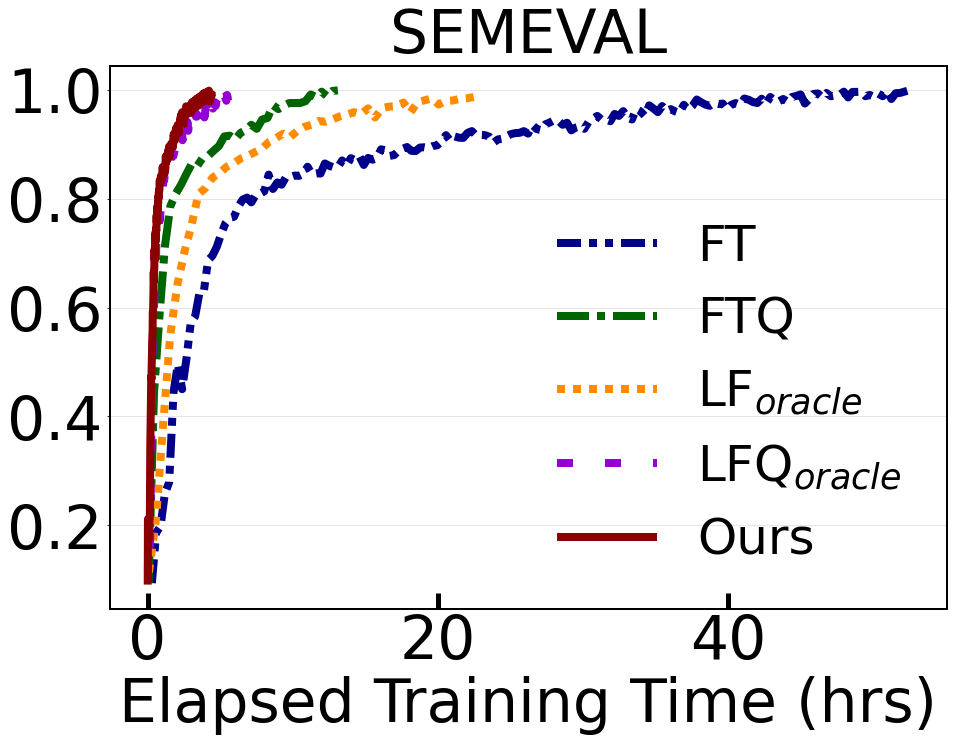

In [7]:
path = "./Baseline/TC_semeval_processed_data.csv"
raw_data = pd.read_csv(path,index_col=0)
column_name = raw_data.columns.values
bw = 1 # both for upload and download bandwidth
batch_num = 20 # per round
multiple = 1 * 20
# overhead
comm = model_size * 2 / bw
comp = latency_rpi * batch_num

# 使用相同的设备
# TX2 / RPI
plt.figure(figsize=(15,10))
plt.title("SEMEVAL",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
# plt.ylabel("Accuracy", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()
from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

backend = "TX2"
heterogenous = 0
straggler = 0
max_acc = 0.8* 0.99

# Optimal Freeze + Origin
# 无cache
multiple = 1 * 20 // 8
if backend == "TX2":
    l = latency_tx2
else:
    l = latency_rpi

# Origin
col = "Origin"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
y_ewm = raw_data.iloc[:,column_name.tolist().index(col)].dropna().ewm(span=3).mean()
# y = [t for t in y if t < 0.8]
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
# time, y = insert_0(time, y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[1], linewidth = lw, label = type[0], linestyle = linestyle[1])
print(col,np.array(time)[-1]/3600)

# Origin
col = "Origin"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
y_ewm = raw_data.iloc[:,column_name.tolist().index(col)].dropna().ewm(span=3).mean()
# y = [t for t in y if t < 0.8]
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm/4, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
# time, y = insert_0(time, y)
time = down_sample(time,5)
y = down_sample(y,5)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[2], linewidth = lw, label = type[1], linestyle = linestyle[2])
print(col,np.array(time)[-1]/3600)

# Freeze-optimal
col = "Freeze: e,0-2"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值

round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
# time, y = insert_0(time, y)
time = down_sample(time,5)
y = down_sample(y,5)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[3], linewidth = lw, label = type[2], linestyle = linestyle[3])
print(col,np.array(time)[-1]/3600)

# Freeze-optimal
col = "Freeze: e,0-2"
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值

round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm/4, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
# time, y = insert_0(time, y)
time = down_sample(time,2)
y = down_sample(y,2)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[4], linewidth = lw, label = type[3], linestyle = linestyle[4])
print(col,np.array(time)[-1]/3600)

# adaptive
# 使用阶梯式adaptive方案来训练，提升0-3freeze方案的效果
multiple = 1 * 20
data = raw_data.iloc[:,column_name.tolist().index("Adapter")].dropna()

time = []
if backend == "TX2":
    l = latency_tx2_cached
else:
    l = latency_rpi_cached

tmp = -1 * multiple # 记录最后一个访问的idx
round_idx = np.array(list(range(0,len(data)))) * multiple # multiple对应eval的频率，和BN的大小
for idx in round_idx:
    m = "A-Freeze: e,0-1"
    time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time_adaptive = time 

time_adaptive, data = cut(time_adaptive, data, max_acc)
data = data[:len(time_adaptive)]
# time_adaptive, data = insert_0(time_adaptive, data)
# plt.plot(time_adaptive,data_ewm, color= color[2],label="Adaptive")
plt.plot(np.array(time_adaptive)/3600, np.array(data)/max_acc, color = color[0], linewidth = lw, label=type[4], linestyle = linestyle[0])
print(sys,np.array(time_adaptive)[-1]/3600)

plt.legend(fontsize=50,ncol = 1,frameon=False)
plt.savefig('../figs/eval-performance-distilbert-semeval.pdf', bbox_inches="tight")

Origin 65.5111111111111 0.777018074
Origin 16.377777777777776 0.777018074
Freeze: e,0-2 36.98666666666666
Freeze: e,0-2 4.623333333333332
Ours 2.030222222222228


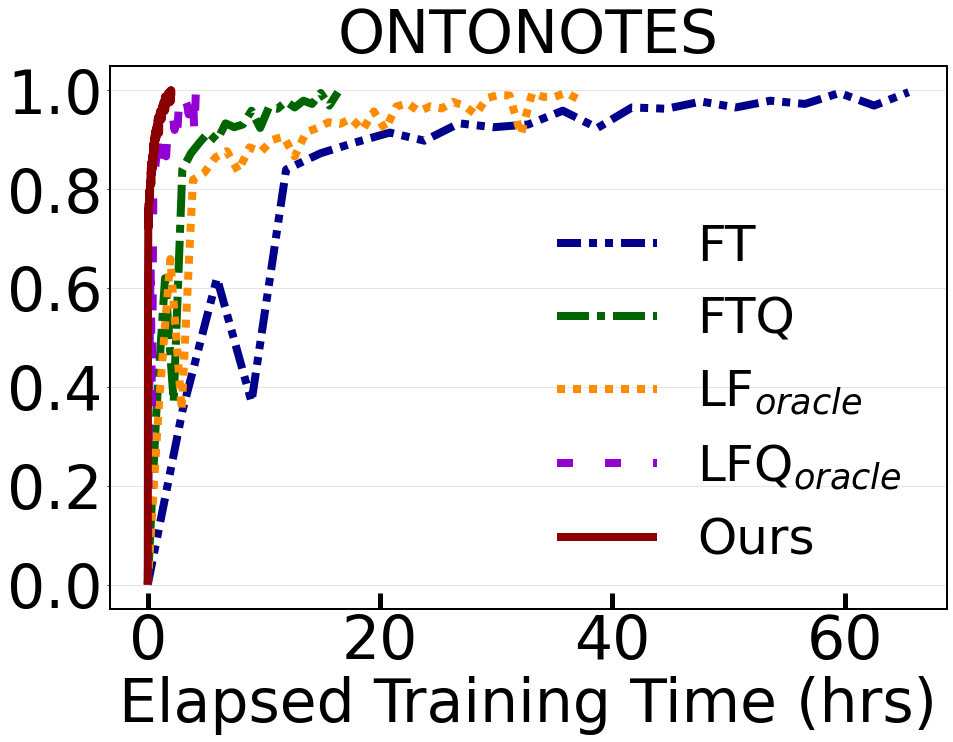

In [8]:
def insert_0(time, y):
    time.insert(0,0)
    y = y.tolist()
    y.insert(0,0)
    return time, y

path = "./Baseline/ST-Adaptive-Case-10-processed-data.csv"
raw_data = pd.read_csv(path,index_col=0)
column_name = raw_data.columns.values

bw = 1 # both for upload and download bandwidth
batch_num = 20 # per round
multiple = 417 // batch_num

# overhead
comm = model_size * 2 / bw
comp = latency_rpi * batch_num

# 使用相同的设备
# TX2 / RPI
plt.figure(figsize=(15,10))
plt.title("ONTONOTES",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Elapsed Training Time (hrs)", fontsize=ft)
# plt.ylabel("Token-F1", fontsize=ft)
plt.grid(color = 'k', linestyle = (0, (1, 1)), axis="y", linewidth = 0.5, alpha=0.4)
border()

from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

backend = "TX2"
heterogenous = 0
straggler = 0
max_acc = 0.78
# plt.ylim(0, 0.799)

# Optimal Freeze + Origin


# 无cache
if backend == "TX2":
    l = latency_tx2
else:
    l = latency_rpi
    
# Origin
col = column_name[-1] 
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
# y = [t for t in y if t < 0.8]
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
time, y = insert_0(time, y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[1], linewidth = lw, label = type[0], linestyle = linestyle[1])
print(col,np.array(time)[-1]/3600, np.array(y)[-1])

# Origin
col = column_name[-1] 
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值
# y = [t for t in y if t < 0.8]
round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1*multiple # 记录最后一个访问的idx
for idx in round_idx:
    time = sum_duration(col, method, comm/4, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time, y = cut(time, y, max_acc)

y = y[:len(time)]
time, y = insert_0(time, y)

plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[2], linewidth = lw, label = type[1], linestyle = linestyle[2])
print(col,np.array(time)[-1]/3600, np.array(y)[-1])

# Freeze-optimal
col = column_name[-3] 
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值

round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
time, y = insert_0(time, y)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[3], linewidth = lw, label = type[2], linestyle = linestyle[3])
print(col,np.array(time)[-1]/3600)

# Freeze-optimal
col = column_name[-3] 
t = []
y = raw_data.iloc[:,column_name.tolist().index(col)].dropna() # 非空的y值

round_idx = np.array(list(range(0,len(y)))) * multiple
time = []
tmp = -1 * multiple # 记录最后一个访问的idx
for idx in round_idx:
    
    time = sum_duration(col, method, comm/8, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    
    tmp = idx
time, y = cut(time, y, max_acc)
y = y[:len(time)]
time, y = insert_0(time, y)
plt.plot(np.array(time)/3600, np.array(y)/max_acc, color= color[4], linewidth = lw, label = type[3], linestyle = linestyle[4])
print(col,np.array(time)[-1]/3600)

# adaptive
# 使用阶梯式adaptive方案来训练，提升0-3freeze方案的效果
data = raw_data.iloc[:,0].dropna()

time = []
if backend == "TX2":
    l = latency_tx2_cached
else:
    l = latency_rpi_cached

tmp = -1 * multiple # 记录最后一个访问的idx
round_idx = np.array(list(range(0,len(data)))) * multiple # multiple对应eval的频率，和BN的大小
for idx in round_idx:
    if idx < 20 * multiple:
        m = "A-Freeze: e,0-4" # method
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    elif idx < 100 * multiple:
        m = "A-Freeze: e,0-3" 
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    elif idx < 400 * multiple: 
        m = "A-Freeze: e,0-2" 
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    elif idx < 600 * multiple: 
        m = "A-Freeze: e,0-1"
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    else: 
        m = "A-Freeze: e,0" 
        time = sum_duration_cached(m, method, comm, idx, tmp, l, latency, batch_num, time, heterogenous, straggler)
    tmp = idx
time_adaptive = time 

time_adaptive, data = cut(time_adaptive, data, max_acc)
data = data[:len(time_adaptive)]
time_adaptive, data = insert_0(time_adaptive, data)
# plt.plot(time_adaptive,data_ewm, color= color[2],label="Adaptive")
plt.plot(np.array(time_adaptive)/3600, np.array(data)/max_acc, color = color[0], linewidth = lw, label=type[4], linestyle = linestyle[0])
print(sys,np.array(time_adaptive)[-1]/3600)

plt.legend(fontsize=50,ncol = 1,frameon=False)
plt.savefig('../figs/eval-performance-distilbert-onto.pdf', bbox_inches="tight")